In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.constants import mu_0
from tqdm import tqdm

# Classes that contain internal properties of the given Ising model
# Class for 1D Ising Model
class IsingModel1D:
    def __init__(self, J, B, N, beta=1):
        self.J = J
        self.mu = mu_0*np.sqrt(3) # given only two orientations (s=1/2)
        self.B = B
        self.beta = beta
        self.N = N
    def Hamiltonian(self, spins): # for a given 1D system with nn interactions
        field_comp = -self.mu*self.B*spins.sum()
        nn_comp = -self.J*self.beta*np.dot(spins,np.roll(spins,shift=1))
        return field_comp + nn_comp
    def H_change(self,spins,spin_idx): # Computes change in Hamiltonian by only looking at nn interactions
        H_local_old = -self.J*self.beta*spins[spin_idx]*(spins[spin_idx-1] + spins[(spin_idx+1) % self.N])
        spins[spin_idx] = -spins[spin_idx] # flip the spin
        H_local_new = -self.J*self.beta*spins[spin_idx]*(spins[spin_idx-1] + spins[(spin_idx+1) % self.N] )
        return H_local_new - H_local_old
    def ising_metropolis(self, n_itrs=1000):
        ''' Takes in a Hamiltonian function (H), lattice dimension (dim) and length(N), and number of iterations (n)
            and returns the spins at each iteration.
        '''
        self.spin_tracker = np.zeros((n_itrs,self.N))
        spins = np.random.choice([1,-1],size=self.N) # initialize lattice
        for n in tqdm(range(n_itrs)):
            s = np.random.randint(0,self.N)
            deltaH = self.H_change(spins, s)
            r = np.exp(-self.beta*(deltaH))
            z = np.random.uniform()
            if r > z: # determining whether to keep flipped spin
                spins[s] = -spins[s]
            self.spin_tracker[n,:] = spins
            
# Class for 2D Ising model
class IsingModel2D(IsingModel1D):
    def __init__(self, J, B, N, beta=1):
        super().__init__(J, B, N, beta)
    def Hamiltonian(self, spins): # for a given D system with nn interactions
        field_comp = -self.mu*self.B*spins.sum()
        nn_comp = 0
        # Only count neighbours right or below to avoid double counting
        for i in range(self.N):
            for j in range(self.N):
                if i + j == 2*(self.N-1): # accounting for periodic boundary conditions
                    nn_comp += spins[i,j]*spins[i,0] + spins[i,j]*spins[0,j]
                elif i == self.N-1:
                    nn_comp += spins[i,j]*spins[i,j+1] + spins[i,j]*spins[0,j]
                elif j == self.N-1:
                    nn_comp += spins[i,j]*spins[i,0] + spins[i,j]*spins[i+1,j]
                else:
                    nn_comp += spins[i,j]*spins[i,j+1] + spins[i,j]*spins[i+1,j]
        nn_comp *= -self.J*self.beta
        return field_comp + nn_comp
    def H_change(self,spins,s):
      s1,s2 = s
      H_local_old = -self.J*self.beta*spins[s]*(spins[(s1+1)%self.N,s2] + spins[s1-1,s2] \
                                                + spins[s1,(s2+1)%self.N] + spins[s1,s2-1])
      # flipping the spins to calculate energy change
      dummy_spins = spins.copy()
      dummy_spins[s] = -dummy_spins[s]
      H_local_new = -self.J*self.beta*dummy_spins[s]*(dummy_spins[(s1+1)%self.N,s2] + dummy_spins[s1-1,s2] \
                                    + dummy_spins[s1,(s2+1)%self.N] + dummy_spins[s1,s2-1])
      return (H_local_new - H_local_old)
    def ising_metropolis(self, n_itrs=1000):
        ''' Takes in a Hamiltonian function (H), length(N), and number of iterations (n)
            and returns the spins at each iteration.
        '''
        self.spin_tracker = np.ones((n_itrs,self.N,self.N))
        spins = np.random.choice([1,-1],size=(self.N, self.N)) # initialize lattice
        # spins = np.ones((self.N,self.N))
        for n in tqdm(range(n_itrs)):
            s = tuple(np.random.randint(0,self.N,(2))) # two indices required for spin position
            deltaH = self.H_change(spins,s)
            r = np.exp(-self.beta*(deltaH))
            z = np.random.uniform()
            if r > z: # determining whether to keep flipped spin
                spins[s] = -spins[s]
            self.spin_tracker[n,:,:] = spins

In [32]:
model = IsingModel1D(J=np.inf,B=0,N=56)
model.ising_metropolis(n_itrs=10**5)

  0%|          | 0/100000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 100000/100000 [00:02<00:00, 39910.62it/s]


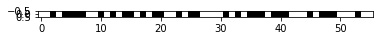

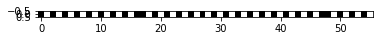

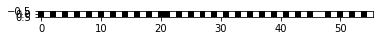

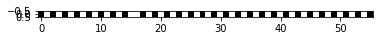

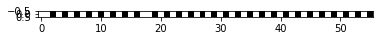

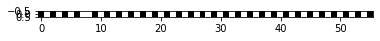

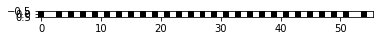

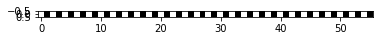

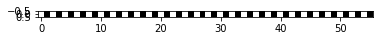

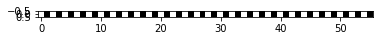

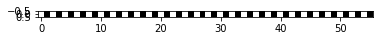

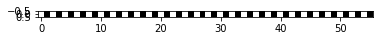

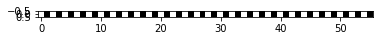

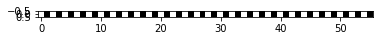

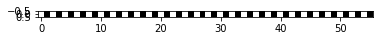

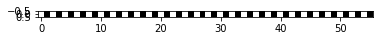

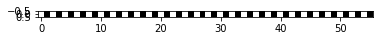

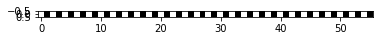

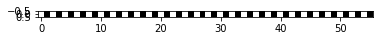

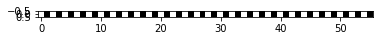

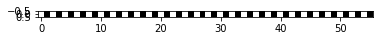

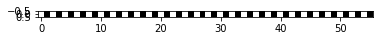

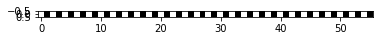

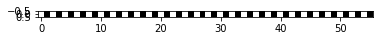

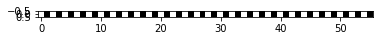

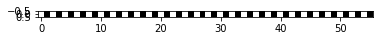

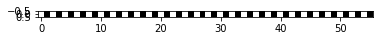

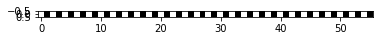

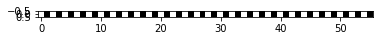

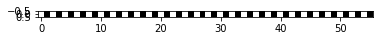

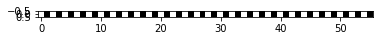

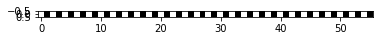

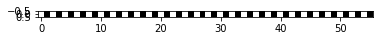

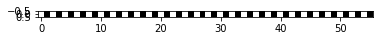

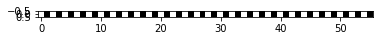

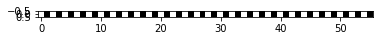

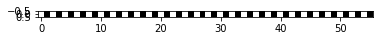

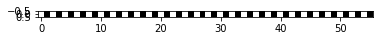

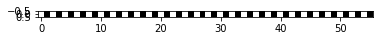

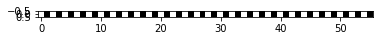

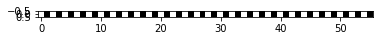

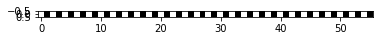

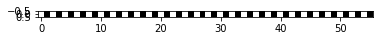

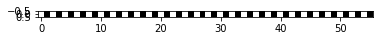

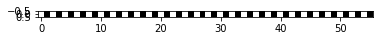

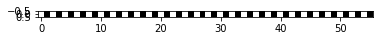

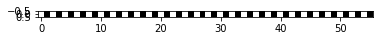

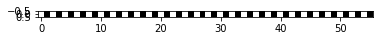

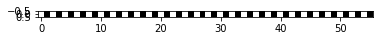

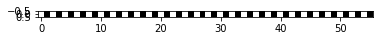

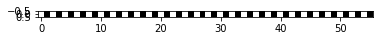

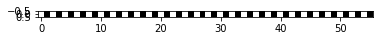

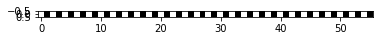

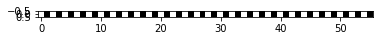

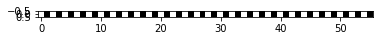

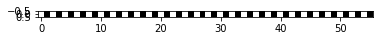

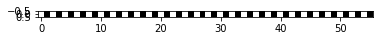

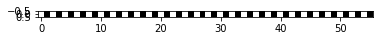

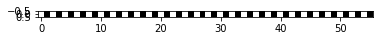

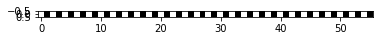

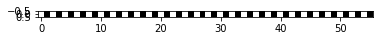

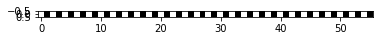

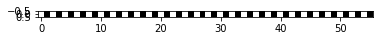

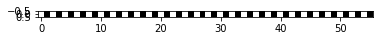

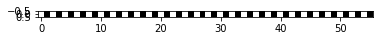

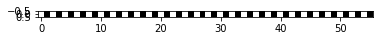

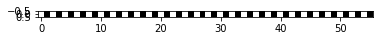

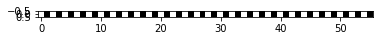

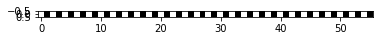

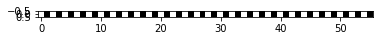

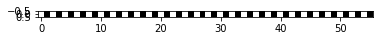

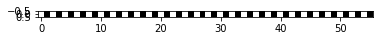

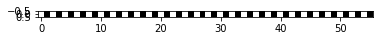

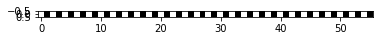

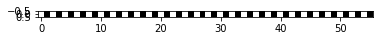

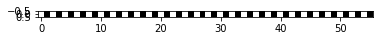

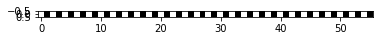

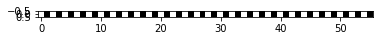

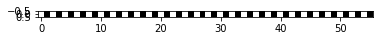

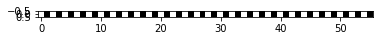

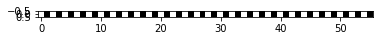

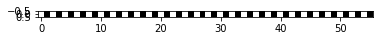

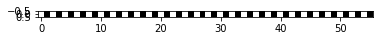

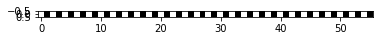

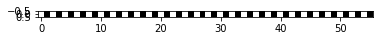

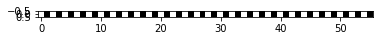

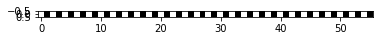

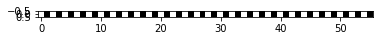

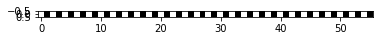

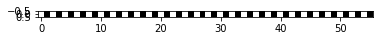

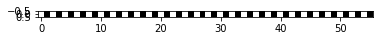

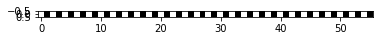

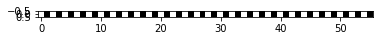

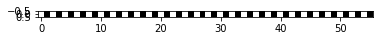

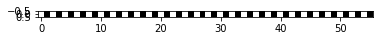

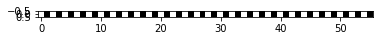

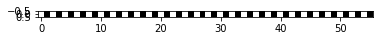

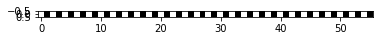

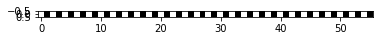

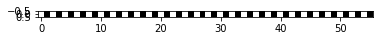

In [34]:
for i in range(0,10**5,1000):
    fig = plt.figure()
    plt.imshow(model.spin_tracker[i,:].reshape(1,56),cmap='gray')
    plt.show()